In [252]:
import pandas as pd
import re
import praw
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import nltk
import warnings
import operator
import matplotlib.pyplot as plt

In [18]:
user_agent = "Reddit_Scrapper 1.0 by /u//FeatureChoice5036"

reddit = praw.Reddit(
 client_id="my-client-id",
 client_secret="my-client-secret",
 user_agent=user_agent
)

In [268]:
headlines = []
date_created = []
avg_score = []
upvote_ratio = []
num_comments = []
num_awards = []
pinned = []

for submission in reddit.subreddit("futurology").hot(limit=None):
    headlines.append(submission.title)
    date_created.append(submission.created_utc)
    avg_score.append(submission.score)
    upvote_ratio.append(submission.upvote_ratio)
    num_comments.append(submission.num_comments)
    num_awards.append(submission.total_awards_received)
    pinned.append(submission.pinned)

r/Futurology's Official Discord - A relaxed place to chill and discuss all things Futurology.
1528980218.0
1160
0.98
52
28
False
Steel maker aims for 90% reduction in direct CO2 emissions by using wind and solar powered electric arc furnace, instead of coking coal. May be carbon neutral by 2030.
1680707416.0
4961
0.96
167
0
False
The Robots Have Finally Come for My Job - Could ChatGPT lay waste to millions of professional jobs, including journalists?
1680701560.0
1775
0.9
709
0
False
AI Is Coming for Voice Actors. Artists Everywhere Should Take Note - No one knows how automation will upend all the arts. But the current turmoil in the voice-over industry may offer some hints
1680696334.0
1633
0.94
443
0
False
This 64-foot hydrogen electric yacht uses solar and sea water to power itself with 'unlimited range'. The team at AQUON has developed a unique system aboard the vessel that can go days at sea without replenishing and may just be able to offer unlimited range without any dependency 

In [184]:
# All fields of PRAW submission objects
vars(submission)

{'comment_limit': 2048,
 'comment_sort': 'confidence',
 '_reddit': <praw.reddit.Reddit at 0x7f8c389cca00>,
 'approved_at_utc': None,
 'subreddit': Subreddit(display_name='Futurology'),
 'selftext': '',
 'author_fullname': 't2_npub6i21',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 0,
 'clicked': False,
 'title': "New study reveals biodiversity loss drove ecological collapse after the 'Great Dying'",
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/Futurology',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': 'environment',
 'downs': 0,
 'thumbnail_height': 105,
 'top_awarded_type': None,
 'hide_score': False,
 'name': 't3_11c9ctr',
 'quarantine': False,
 'link_flair_text_color': 'dark',
 'upvote_ratio': 0.97,
 'author_flair_background_color': None,
 'ups': 780,
 'total_awards_received': 0,
 'media_embed': {},
 'thumbnail_width': 140,
 'author_flair_template_id': None,
 'is_original_content': False,
 'user_reports': [],
 'secure_media': None,
 'is_reddit_media_

In [269]:
reddit_df = pd.DataFrame({'Title': headlines, 
                          'Date': date_created,
                          'Average Score': avg_score,
                          'Upvote Ratio': upvote_ratio,
                          'Number of Comments': num_comments,
                          'Awards Received': num_awards,
                          'Pinned': pinned
                         })
reddit_df.head()

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received,Pinned
0,r/Futurology's Official Discord - A relaxed pl...,1.528980e+09,1160,0.98,52,28,False
1,Steel maker aims for 90% reduction in direct C...,1.680707e+09,4961,0.96,167,0,False
2,The Robots Have Finally Come for My Job - Coul...,1.680702e+09,1775,0.90,709,0,False
3,AI Is Coming for Voice Actors. Artists Everywh...,1.680696e+09,1633,0.94,443,0,False
4,This 64-foot hydrogen electric yacht uses sola...,1.680664e+09,7476,0.95,372,0,False


In [270]:
reddit_df[reddit_df.Pinned==True]

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received,Pinned


In [271]:
# Delete 'Pinned' column as it's no longer required
reddit_df = reddit_df.drop('Pinned', axis=1)

In [273]:
# Delete duplicate posts
reddit_df = reddit_df.drop_duplicates(subset='Title', keep='first')
reddit_df.Title.duplicated().sum()

0

In [274]:
# Convert 'Date' column from Unix epoch to datetime
reddit_df['Date'] = pd.to_datetime(reddit_df['Date'],unit='s').dt.date
reddit_df.head()

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received
0,r/Futurology's Official Discord - A relaxed pl...,2018-06-14,1160,0.98,52,28
1,Steel maker aims for 90% reduction in direct C...,2023-04-05,4961,0.96,167,0
2,The Robots Have Finally Come for My Job - Coul...,2023-04-05,1775,0.90,709,0
3,AI Is Coming for Voice Actors. Artists Everywh...,2023-04-05,1633,0.94,443,0
4,This 64-foot hydrogen electric yacht uses sola...,2023-04-05,7476,0.95,372,0


In [275]:
def text_clean(text):
    text = re.sub(r"(?<!\d)[.,;:](?!\d)", '', text, 0) # Remove all punctuation except in digits
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)     # Remove emojis

    return text
                  
# Cleaning the text
reddit_df['Title']= reddit_df['Title'].apply(text_clean)
reddit_df.head()

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received
0,r/Futurology's Official Discord - A relaxed pl...,2018-06-14,1160,0.98,52,28
1,Steel maker aims for 90% reduction in direct C...,2023-04-05,4961,0.96,167,0
2,The Robots Have Finally Come for My Job - Coul...,2023-04-05,1775,0.90,709,0
3,AI Is Coming for Voice Actors Artists Everywhe...,2023-04-05,1633,0.94,443,0
4,This 64-foot hydrogen electric yacht uses sola...,2023-04-05,7476,0.95,372,0


In [276]:
# Create a function to get Subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
# Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create new column for what we just did and add it to reddit_df dataframe
reddit_df['Subjectivity'] = reddit_df['Title'].apply(getSubjectivity)
reddit_df['Polarity'] = reddit_df['Title'].apply(getPolarity)
reddit_df.head()

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received,Subjectivity,Polarity
0,r/Futurology's Official Discord - A relaxed pl...,2018-06-14,1160,0.98,52,28,0.000000,0.000000
1,Steel maker aims for 90% reduction in direct C...,2023-04-05,4961,0.96,167,0,0.400000,0.100000
2,The Robots Have Finally Come for My Job - Coul...,2023-04-05,1775,0.90,709,0,0.366667,-0.033333
3,AI Is Coming for Voice Actors Artists Everywhe...,2023-04-05,1633,0.94,443,0,0.400000,0.000000
4,This 64-foot hydrogen electric yacht uses sola...,2023-04-05,7476,0.95,372,0,0.641667,0.325000


In [277]:
# Group the range of Polarity into different categories
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
reddit_df['Sentiment'] = reddit_df['Polarity'].apply(getSentiment)
reddit_df.tail(50)

,Title,Date,Average Score,Upvote Ratio,Number of Comments,Awards Received,Subjectivity,Polarity,Sentiment
681,Stem cell therapy may reduce risk of heart att...,2023-03-03,102,0.97,5,0,0.435714,-0.051190,Negative
682,End ‘colonial’ approach to space exploration s...,2023-03-04,0,0.38,24,0,0.000000,0.000000,Neutral
683,The future of world politics I think will retu...,2023-03-04,0,0.38,40,0,0.125000,0.000000,Neutral
684,A joint US/Australian government-funded study ...,2023-03-02,8283,0.94,1018,1,0.400000,0.000000,Neutral
685,Is This Elementary School Near Pittsburgh the ...,2023-03-03,36,1.00,4,0,0.554167,0.200000,Positive
686,Is an AI catastrophe imminent?,2023-03-04,0,0.36,12,0,0.000000,0.000000,Neutral
687,The Looming Crisis of Melting Glaciers What It...,2023-03-03,19,0.75,5,0,0.000000,0.000000,Neutral
688,Supermarkets are ‘Quiet Quitting’ Meat and Dairy,2023-03-03,8,0.53,55,0,0.333333,0.000000,Neutral
689,Artificial intelligence is on the brink of an ...,2023-03-02,1341,0.88,465,0,1.000000,-0.600000,Negative
690,The future of urban mobility,2023-03-04,0,0.34,18,0,0.062500,0.000000,Neutral


In [280]:
reddit_df.columns

Index(['Title', 'Date', 'Average Score', 'Upvote Ratio', 'Number of Comments',
       'Awards Received', 'Subjectivity', 'Polarity', 'Sentiment'],
      dtype='object')

In [279]:
reddit_df.to_csv('/Users/younsu/Downloads/redditSentiment.csv', index=False)
reddit_df.to_csv('/Users/younsu/subreddit_sentiment/redditSentiment.csv', index=False)

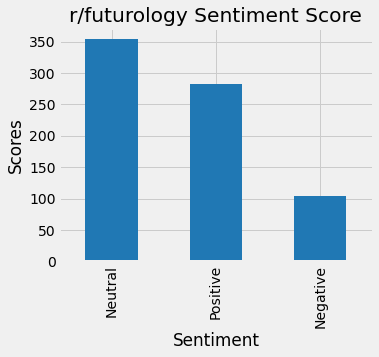

In [245]:
#Plot the values count of sentiment
plt.title('r/futurology Sentiment Score')
plt.xlabel('Sentiment')
plt.ylabel('Scores')
plt.rcParams['figure.figsize'] = (5,4)
reddit_df['Sentiment'].value_counts().plot(kind='bar', color='#2078B4')
plt.show()

In [246]:
stopwords_wc = STOPWORDS
print(stopwords_wc)

{"he's", 'however', 'of', "there's", "here's", 'no', 'can', 'through', "shan't", "it's", 'what', 'his', 'is', 'some', "why's", 'under', 'would', "when's", 'my', "he'll", "that's", 'about', 'up', 'had', "who's", 'been', "wouldn't", 'be', 'than', 'r', 'by', "they'll", 'there', "he'd", 'itself', 'here', 'for', 'which', 'me', 'like', 'why', 'more', "we've", 'both', "she'd", 'as', 'himself', 'again', "they'd", 'theirs', 'have', 'down', 'if', 'their', 'herself', 'does', "hasn't", 'she', 'before', 'themselves', 'that', 'after', 'any', 'its', 'are', "weren't", 'else', 'her', 'against', 'we', 'your', "we're", 'ours', "you'd", 'just', "can't", "she'll", 'over', 'few', "they've", "i'd", 'other', 'because', 'otherwise', "you're", 'ought', 'then', 'whom', 'has', 'during', "i've", "doesn't", "aren't", 'cannot', 'only', "shouldn't", 'those', 'off', 'http', 'who', "you've", 'at', 'with', 'but', 'or', 'yourself', 'yours', "we'll", 'you', 'once', "mustn't", 'this', 'a', "wasn't", 'where', 'get', 'most',

In [247]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [248]:
stopwords_all = list(set(list(stopwords_wc) + stopwords.words('english')))
print(stopwords_all)

["he's", 'however', 'of', "there's", "here's", 'no', 't', 'can', 'through', 'doesn', "shan't", "it's", 'what', 'his', 'is', 'some', "why's", "should've", 'shan', 'under', 'would', "when's", 'my', "he'll", "that's", 'about', 'up', 'had', "who's", 'been', "wouldn't", 'be', 'than', 'r', 'by', 'haven', "they'll", 'there', "he'd", 'itself', "mightn't", 'm', 'here', 'for', 'which', 'me', 'like', 'why', 'more', "we've", 'both', "she'd", 'as', 'himself', 'won', 'again', "they'd", 'theirs', 'have', 'down', 'needn', 'if', 'their', 'herself', 'does', "hasn't", 'she', 'before', 'themselves', 'that', 'after', 'any', 'its', 'are', "weren't", 'else', 'her', 'against', 'isn', 'we', 'your', "we're", 'ours', 'don', "you'd", 'just', 'll', "can't", "she'll", 'aren', 'over', 'few', "they've", 'wouldn', "i'd", 'other', 'because', 'otherwise', "you're", 'ought', 'then', 'whom', 'has', 'during', 'y', "i've", "doesn't", 'o', "aren't", 'mightn', 'cannot', 'only', "shouldn't", 'those', 'off', 'http', 'who', "you

(-0.5, 999.5, 599.5, -0.5)

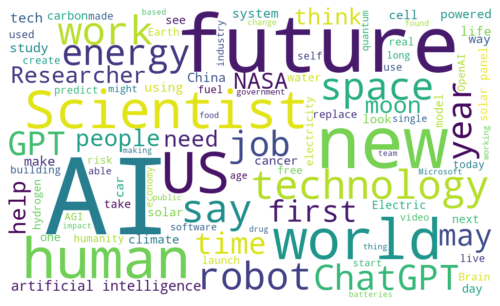

In [249]:
text = ' '.join( [posts for posts in reddit_df['Title']] )

wordcloud = WordCloud(width=1000, height = 600, 
                      max_words = 100, 
                      stopwords = stopwords_all, 
                      background_color='white').generate(text)

plt.figure(figsize=(10,5), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [254]:
freq_dict = WordCloud(max_words = 100, 
                      stopwords = stopwords_all,).process_text(text)
dict( sorted(freq_dict.items(), key=operator.itemgetter(1),reverse=True))

{'AI': 181,
 'future': 86,
 'new': 73,
 'US': 42,
 'world': 40,
 'human': 40,
 'Scientist': 35,
 'technology': 31,
 'work': 30,
 'say': 30,
 'robot': 28,
 'space': 28,
 'energy': 25,
 'job': 23,
 'ChatGPT': 23,
 'year': 22,
 'GPT': 21,
 'first': 21,
 'time': 21,
 'may': 21,
 'people': 20,
 'moon': 20,
 'Researcher': 19,
 'help': 18,
 'NASA': 18,
 'need': 18,
 'think': 18,
 'artificial intelligence': 18,
 'tech': 17,
 'study': 16,
 'make': 16,
 'China': 15,
 'using': 15,
 'system': 15,
 'life': 15,
 'climate': 14,
 'cell': 14,
 'solar': 14,
 'way': 14,
 'look': 14,
 'cancer': 14,
 'powered': 14,
 'car': 14,
 'carbon': 13,
 'see': 13,
 'day': 13,
 'one': 13,
 'Electric': 12,
 'water': 12,
 'model': 12,
 'next': 12,
 'take': 12,
 'solar panel': 12,
 'hydrogen': 11,
 'electricity': 11,
 'real': 11,
 'used': 11,
 'replace': 11,
 'free': 11,
 'Earth': 11,
 'Brain': 11,
 'launch': 11,
 'humanity': 10,
 'risk': 10,
 'self': 10,
 'today': 10,
 'AGI': 10,
 'made': 10,
 'use': 10,
 'OpenAI': 10,


In [256]:
pd.DataFrame(dict( sorted(freq_dict.items(), key=operator.itemgetter(1),reverse=True)).items(), 
             columns=['Word', 'Frequency']).head(50)

,Word,Frequency
0,AI,181
1,future,86
2,new,73
3,US,42
4,world,40
5,human,40
6,Scientist,35
7,technology,31
8,work,30
9,say,30
